# Assessment of greedy mode selection

In [ ]:
from os.path import join
from os import makedirs
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from flowtorch.analysis import DMD
from utils import normalize_frequency, add_oat_patch

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "/home/andre/Development/naca0012_shock_buffet/run/oat15"
path = "./output/oat15_analysis/dmd_mode_selection"

makedirs(path, exist_ok=True)

In [7]:
CHORD = 0.15
U_INF = 238.59

times = pt.load(join(data, "oat15_tandem_times.pt"))[::20]
vertices = pt.load(join(data, "vertices_and_masks.pt"))
area = vertices["area_small"]
weight = area.sqrt().unsqueeze(-1)
x = vertices["x_small"] / CHORD
z = vertices["z_small"] / CHORD
del vertices
start_at, end_at = 101, 501 # encloses 2 cycles
dt = times[1] - times[0]

In [8]:
vel_x = pt.load(join(data, "vel_x_small_every10.pt"))[:, start_at:end_at:2]
vel_z = pt.load(join(data, "vel_z_small_every10.pt"))[:, start_at:end_at:2]
dm = pt.cat((vel_x, vel_z)) * weight.repeat((2, 1))
del vel_x, vel_z

In [9]:
dmd = DMD(dm, dt, optimal=True)

In [10]:
n_modes = int(dmd.modes.shape[1] / 2)
f_sort_ind = dmd.frequency.sort().indices

In [11]:
def add_complex_conjugate(mode_i):
    return (dmd.frequency.abs() - dmd.frequency[mode_i].abs()).abs().topk(2, largest=False).indices

def select_next_mode(top_modes):
    top_mode, top_err = 0, 1e15
    for mi in f_sort_ind[:n_modes]:
        if mi not in top_modes:
            use_modes = top_modes + add_complex_conjugate(mi).tolist()
            err = (dmd.partial_reconstruction(use_modes) - dm).norm()
            if err < top_err:
                top_mode, top_err = mi, err
    return top_mode, top_err

In [12]:
top_modes = f_sort_ind[dmd.frequency[f_sort_ind].abs() < 0.001].tolist()
rec_err = []
rec_err.append((dmd.partial_reconstruction(top_modes) - dm).norm())

top_n = 20
for i in range(top_n):
    print(f"\rSelecting mode number {i+1}/{top_n}", end="")
    top_mode, top_err = select_next_mode(top_modes)
    top_modes.extend(add_complex_conjugate(top_mode).tolist())
    rec_err.append(top_err.item())

Selecting mode number 20/20

In [13]:
max_rec_err = (dmd.partial_reconstruction(dmd.top_modes(1, integral=True)) - dmd._dm).norm()

In [16]:
min_rec_err = dmd.reconstruction_error.norm()

In [56]:
rec_err_int, added_mode = [], []
for i in range(1, 42, 2):
    top_i = dmd.top_modes(i, integral=True)
    top_i_pos = [mi for mi in top_i if dmd.frequency[mi] >= 0.0]
    for mi in top_i_pos:
        if mi.item() not in added_mode:
            added_mode.append(mi.item())
    rec_err_int.append((dmd.partial_reconstruction(top_i) - dmd._dm).norm())

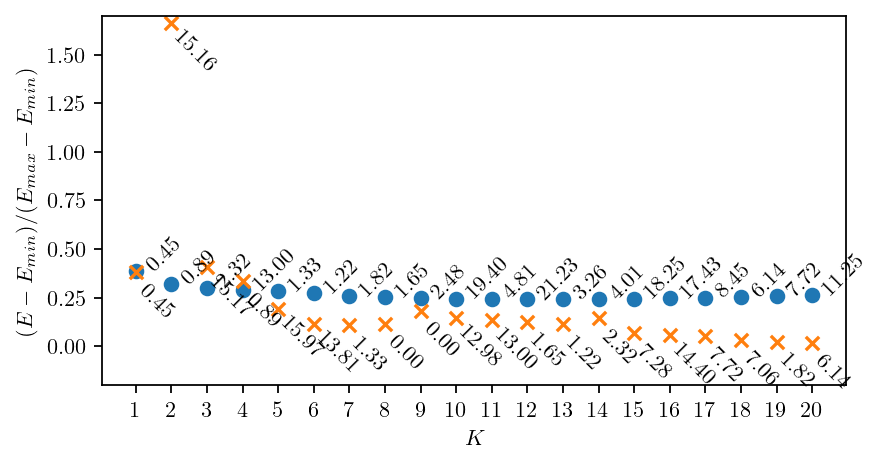

In [74]:
fig, ax = plt.subplots(figsize=(6, 3))
imp = [(r-min_rec_err) / (max_rec_err-min_rec_err) for r in rec_err[1:]]
imp_int = [(r-min_rec_err) / (max_rec_err-min_rec_err) for r in rec_err_int[1:]]
top_pos = [m for m in top_modes if dmd.frequency[m] > 0.001]
ax.scatter(range(1, len(imp)+1), imp)
ax.scatter(range(1, len(imp_int)+1), imp_int, marker="x")
for i, im in enumerate(imp):
    ax.text(i+1.2, im, f"${normalize_frequency(dmd.frequency[top_pos[i]], CHORD, U_INF):2.2f}$", rotation=45)
for i, mi in enumerate(added_mode[1:-1]):
    ax.text(i+1.0, imp_int[i]-0.15, f"${normalize_frequency(dmd.frequency[mi], CHORD, U_INF):2.2f}$", rotation=-45, va="center")
ax.set_xlabel(r"$K$")
ax.set_ylabel(r"$(E-E_{min})/(E_{max}-E_{min})$")
ax.set_xticks([i for i in range(1, 21)])
ax.set_ylim(-0.2, 1.7)
plt.show()

In [78]:
for i, ii in zip(imp, imp_int):
    print(i.item(), ii.item())

0.38584211468696594 0.3815764784812927
0.31832268834114075 1.6636275053024292
0.3015332520008087 0.40530863404273987
0.2897481322288513 0.33589401841163635
0.28193652629852295 0.19328252971172333
0.27224740386009216 0.11627960205078125
0.25929686427116394 0.10870303213596344
0.2538331151008606 0.11546973884105682
0.24835482239723206 0.18248233199119568
0.24487361311912537 0.14647352695465088
0.24421004951000214 0.1359209418296814
0.24364839494228363 0.12562327086925507
0.24345426261425018 0.11244946718215942
0.24375870823860168 0.14371129870414734
0.24443331360816956 0.06824057549238205
0.24720537662506104 0.05571452155709267
0.25037887692451477 0.050482891499996185
0.2538886070251465 0.030324628576636314
0.2580181658267975 0.023915372788906097
0.2615722715854645 0.01873074658215046


In [202]:
def add_mode_symmetric(ax, mode, n_levels=60):
    vmin, vmax = mode.min(), mode.max()
    vmax = max(vmin.abs(), vmax.abs())
    vmin = -vmax
    levels = pt.linspace(vmin, vmax, n_levels)
    ax.tricontourf(x, z, mode, levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")

In [ ]:
n_modes = 5
n_points = weight.shape[0]
fig, axarr = plt.subplots(n_modes, 2, figsize=(6, 1*n_modes), sharex=True, sharey=True)

for i, mi in enumerate(top_pos[:n_modes]):
    add_mode_symmetric(axarr[i, 0], dmd.modes[:n_points, mi].real/weight.squeeze())
    add_mode_symmetric(axarr[i, 1], dmd.modes[n_points:, mi].real/weight.squeeze())
    axarr[i, 0].set_title(r"$\Re (u_x)$" + f", {normalize_frequency(dmd.frequency[mi], CHORD, U_INF):2.2f}")
    axarr[i, 1].set_title(r"$\Re (u_z)$" + f", {normalize_frequency(dmd.frequency[mi], CHORD, U_INF):2.2f}")
    for ax in axarr.flatten():
        ax.set_aspect("equal")
        add_oat_patch(ax)
        ax.set_ylim(-0.2, 0.5)
        ax.set_xlim(-0.1, 2.5)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{z}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()